In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
offset = 1e-8
# clipping_radius = 1
sigma_noise = 0.1
learning_rate = 0.001

In [16]:
# Training step function
def train_step(model, images, labels,loss_fn, train_loss, train_accuracy, optimizer, clipping_radius):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(images)
        loss = loss_fn(labels, predictions)
    
    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    modified_gradients = custom_gradient_function(clipping_radius, gradients, sigma_noise)

    # Apply gradients
    optimizer.apply_gradients(zip(modified_gradients, model.trainable_variables))
    
    # Update metrics
    train_loss(loss)
    train_accuracy(labels, predictions)
    return loss


def custom_gradient_function(clipping_radius, gradients,noise_scale):
    # Modify gradients (example: scaling gradients by 0.5)
    # modified_gradients = []
    # for grad in gradients:
    #     gradient_norm = tf.norm(grad, axis=0)  #todo maybe axis=1?
    #     clipped_gradient_norm = tf.minimum(gradient_norm, clipping_radius)
    #     clipped_gradient = grad * (clipped_gradient_norm / (gradient_norm + offset))
    # 
    #     modified_gradients.append(clipped_gradient + np.random.normal(0, sigma_noise, size=grad.shape))
    clipped_gradients = [tf.clip_by_value(grad, -clipping_radius, clipping_radius) for grad in gradients]

    noisy_gradients = [grad + np.random.laplace(0, noise_scale,tf.shape(grad)) for grad in clipped_gradients]
    return noisy_gradients

In [17]:
def load_datasets():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)
    return x_train, y_train, x_test, y_test

In [18]:
def model_loss_accuracy(clipping_radius, x_train, y_train, x_test, y_test):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)), 
    tf.keras.layers.Dense(10)])
    
    # Define loss and optimizer
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
    
    # Train the model
    epochs = 5
    epoch_list = []
    loss_list = []
    accuracy_list = []
    for epoch in range(epochs):
        for images, labels in train_dataset:
            loss = train_step(model, images, labels, loss_fn, train_loss, train_accuracy, optimizer, clipping_radius)
        epoch_list.append(epoch + 1)
        loss_list.append(train_loss.result().numpy())
        accuracy_list.append(train_accuracy.result().numpy())
    
        print(f'Clipping Radius: {clipping_radius}, Epoch {epoch+1}, Loss: {np.round(train_loss.result(),2)} %, Accuracy: {train_accuracy.result()} %')

    # Evaluate the model
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
    for test_images, test_labels in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32):
        predictions = model(test_images)
        t_loss = loss_fn(test_labels, predictions)
        
        test_loss(t_loss)
        test_accuracy(test_labels, predictions)
    
    print(f'Test Loss: {test_loss.result()}, Test Accuracy: {test_accuracy.result()}')
    return [epoch_list, loss_list, accuracy_list, test_loss.result(),test_accuracy.result()]

In [19]:
x_train, y_train, x_test, y_test = load_datasets()
# res = model_loss_accuracy(1, x_train, y_train, x_test, y_test)

In [20]:
# # Plotting the results
# plt.figure(figsize=(12, 6))
# plt.plot(res[0], res[1], label='Loss')
# plt.plot(res[0],res[2], label='Accuracy')
# plt.xlabel('Epoch')  
# plt.title('Training Loss')
# plt.legend()
# 
# plt.show()
clipping_radii = [0.1, 0.5, 1, 5]
results = [model_loss_accuracy(c, x_train, y_train, x_test, y_test) for c in clipping_radii]

Clipping Radius: 0.1, Epoch 1, Loss: 0.7893102765083313 %, Accuracy: 0.7957833409309387 %
Clipping Radius: 0.1, Epoch 2, Loss: 0.5977604985237122 %, Accuracy: 0.8410166501998901 %
Clipping Radius: 0.1, Epoch 3, Loss: 0.5175614356994629 %, Accuracy: 0.860105574131012 %
Clipping Radius: 0.1, Epoch 4, Loss: 0.4704020917415619 %, Accuracy: 0.8713916540145874 %
Clipping Radius: 0.1, Epoch 5, Loss: 0.43822380900382996 %, Accuracy: 0.8795133233070374 %
Test Loss: 0.2925613820552826, Test Accuracy: 0.9162999987602234
Clipping Radius: 0.5, Epoch 1, Loss: 0.7811856865882874 %, Accuracy: 0.8071833252906799 %
Clipping Radius: 0.5, Epoch 2, Loss: 0.5905164480209351 %, Accuracy: 0.8477916717529297 %
Clipping Radius: 0.5, Epoch 3, Loss: 0.5114491581916809 %, Accuracy: 0.8647666573524475 %
Clipping Radius: 0.5, Epoch 4, Loss: 0.4655921459197998 %, Accuracy: 0.875041663646698 %
Clipping Radius: 0.5, Epoch 5, Loss: 0.43463170528411865 %, Accuracy: 0.8823400139808655 %
Test Loss: 0.28763899207115173, Tes

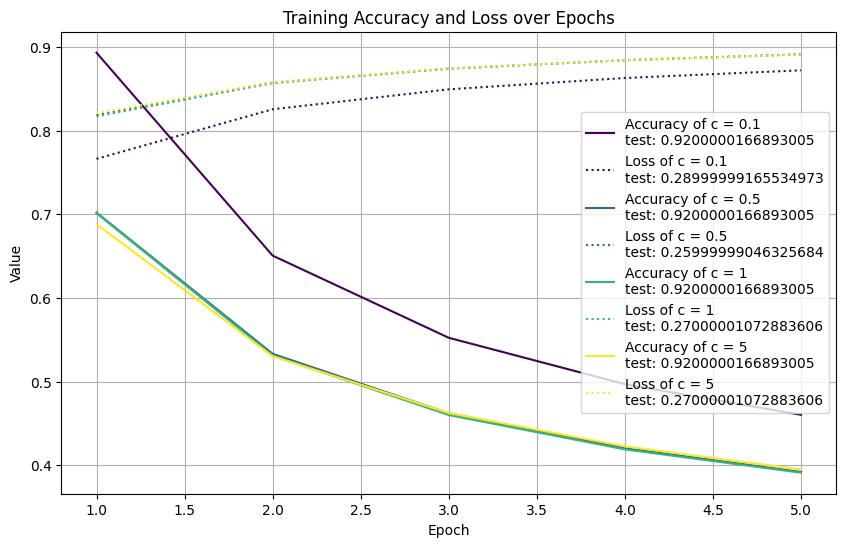

In [10]:
# Plot the results
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(clipping_radii)))

for i, res in enumerate(results):
    epochs, accuracy, loss, test_loss, test_accuracy = res
    plt.plot(epochs, accuracy, label=f'Accuracy of c = {clipping_radii[i]}\n test: {np.round(res[4], 2)}', color=colors[i])
    plt.plot(epochs, loss, linestyle=':', label=f'Loss of c = {clipping_radii[i]}\ntest: {np.round(res[3], 2)}', color=colors[i])
    # plt.text(f"test accuracy: {np.round(res[4], 4)}, test loss: {np.round(res[3], 4)}", fontsize=9, color=colors[i], ha='right')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Second method

In [22]:

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define clipping radii to test
clipping_radii = [0.1, 0.5, 1.0, 2.0, 5.0]


In [28]:

# Function to create and train the model
def train_model(clipping_radius):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(28 * 28,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])



    @tf.function
    def custom_train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = loss_fn(targets, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(grad, -clipping_radius, clipping_radius) for grad in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
        
        return loss
    
    # Train the model
    epochs = 5
    for epoch in range(epochs):
        train_loss = 0
        for inputs, targets in zip(x_train, y_train):
            loss = custom_train_step(np.expand_dims(inputs, 0), np.expand_dims(targets, 0))
            train_loss += loss

        train_loss /= len(x_train)
        print(f'Epoch {epoch+1}, Clipping Radius: {clipping_radius}, Train Loss: {train_loss}')

    # Evaluate the model
    train_accuracy = model.evaluate(x_train, y_train, verbose=0)[1]
    test_accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    test_loss = model.evaluate(x_test, y_test, verbose=0)[0]

    return train_accuracy, test_accuracy, train_loss, test_loss

# Train and evaluate models with different clipping radii
results = []
for radius in clipping_radii:
    train_acc, test_acc, train_loss, test_loss = train_model(radius)
    results.append((radius, train_acc, test_acc, train_loss, test_loss))

# Print results
print('Clipping Radius | Train Acc | Test Acc | Train Loss | Test Loss')
for radius, train_acc, test_acc, train_loss, test_loss in results:
    print(f'{radius:8.2f} | {train_acc:9.4f} | {test_acc:8.4f} | {train_loss:10.4f} | {test_loss:9.4f}')

Epoch 1, Clipping Radius: 0.1, Train Loss: 0.34176963567733765
Epoch 2, Clipping Radius: 0.1, Train Loss: 0.30109840631484985
Epoch 3, Clipping Radius: 0.1, Train Loss: 0.2735956609249115
Epoch 4, Clipping Radius: 0.1, Train Loss: 0.2641826570034027
Epoch 5, Clipping Radius: 0.1, Train Loss: 0.2682923674583435
Epoch 1, Clipping Radius: 0.5, Train Loss: 0.25382307171821594
Epoch 2, Clipping Radius: 0.5, Train Loss: 0.21192124485969543
Epoch 3, Clipping Radius: 0.5, Train Loss: 0.22115129232406616
Epoch 4, Clipping Radius: 0.5, Train Loss: 0.251892626285553
Epoch 5, Clipping Radius: 0.5, Train Loss: 0.32645389437675476
Epoch 1, Clipping Radius: 1.0, Train Loss: 0.23815768957138062
Epoch 2, Clipping Radius: 1.0, Train Loss: 0.17904822528362274
Epoch 3, Clipping Radius: 1.0, Train Loss: 0.17296777665615082
Epoch 4, Clipping Radius: 1.0, Train Loss: 0.1720883995294571
Epoch 5, Clipping Radius: 1.0, Train Loss: 0.18391570448875427
Epoch 1, Clipping Radius: 2.0, Train Loss: 0.2200051695108413